# Correlation between yields and soil nutrients

## Initial exploratory analysis

In [10]:
# Load main libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Load and check data
df=pd.read_csv('data/G01_2018_2022.csv')
df.head(3)

,Year,Sample Id,Nitrogen(%),Sulfur(%),Phosphorus(%),Potassium(%),Magnesium(%),Calcium(%),Sodium(%),Boron(ppm),Zinc(ppm),Maganese(ppm),Iron(ppm),Copper(ppm),Aluminum(ppm),Chloride(%),Yield (lbs/acre)
0,2018,35A,2.39,0.20,0.13,1.64,1.02,4.68,0.03,43,52,130,105,14,49,NaN,968
1,2018,35B,2.38,0.17,0.13,1.65,0.98,5.23,0.03,41,27,96,107,3,52,NaN,968
2,2018,44,2.49,0.20,0.12,2.16,0.90,3.88,0.03,42,58,119,109,2,54,NaN,2416


In [12]:
# Chloride values are missing in several samples, drop the column
df.drop(columns=['Chloride(%)'],inplace=True)


In [13]:
df.columns

Index(['Year', 'Sample Id ', 'Nitrogen(%)', 'Sulfur(%)', 'Phosphorus(%)',
       'Potassium(%)', 'Magnesium(%)', 'Calcium(%)', 'Sodium(%)', 'Boron(ppm)',
       'Zinc(ppm)', 'Maganese(ppm)', 'Iron(ppm)', 'Copper(ppm)',
       'Aluminum(ppm)', 'Yield (lbs/acre)'],
      dtype='object')

### Correlations between features

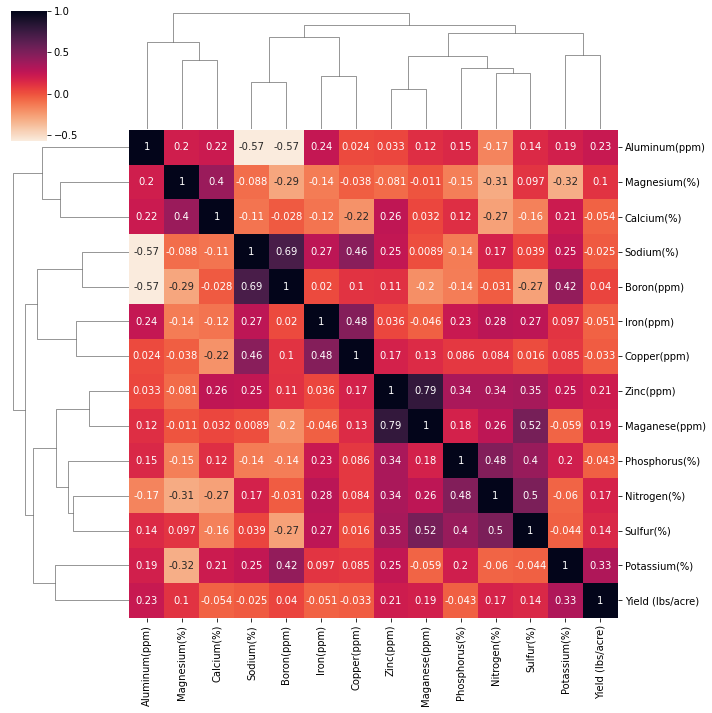

In [14]:
# Check Pearson correlations
sns.clustermap(df.drop(columns=['Year','Sample Id ']).corr(),cmap="rocket_r",annot=True)

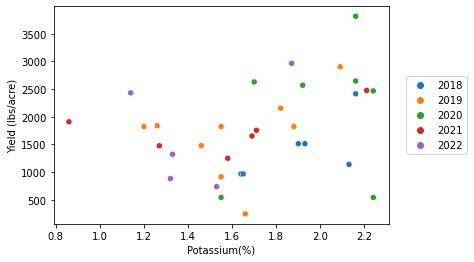

In [15]:
# K has the strongest correlation, see how the data looks...
g=sns.scatterplot(data=df,x='Potassium(%)',y='Yield (lbs/acre)',hue='Year',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

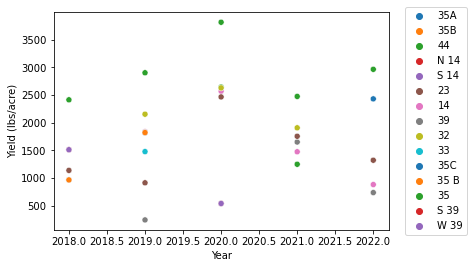

In [16]:
# Not very strong; see if there is any bias by year
g=sns.scatterplot(data=df,x='Year',y='Yield (lbs/acre)',hue='Sample Id ',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

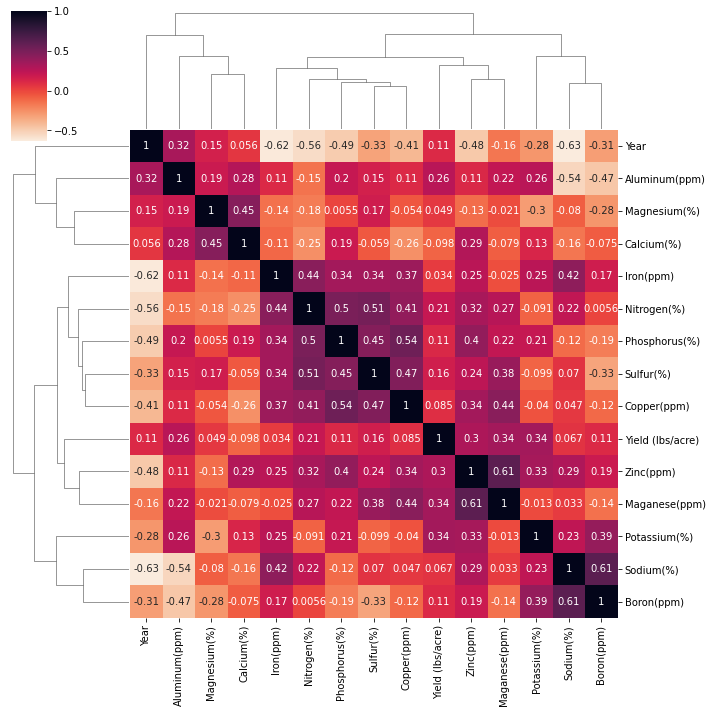

In [17]:
# Check rank correlation
sns.clustermap(df.drop(columns=['Sample Id ']).corr(method='spearman'),cmap="rocket_r",annot=True)

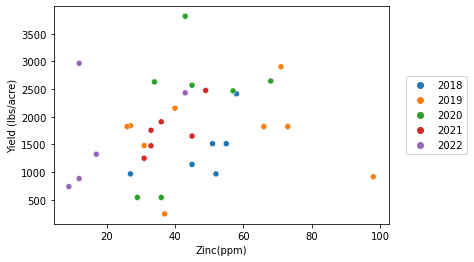

In [18]:
# Check the stronges correlations (Zinc and Manganese)
g=sns.scatterplot(data=df,x='Zinc(ppm)',y='Yield (lbs/acre)',hue='Year',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

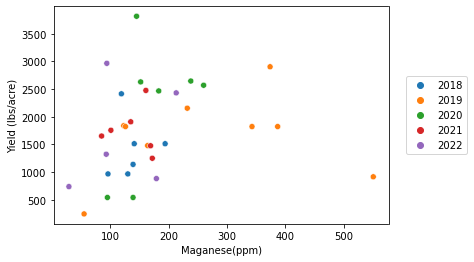

In [19]:
# Check the stronges correlations (Zinc and Manganese)
g=sns.scatterplot(data=df,x='Maganese(ppm)',y='Yield (lbs/acre)',hue='Year',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

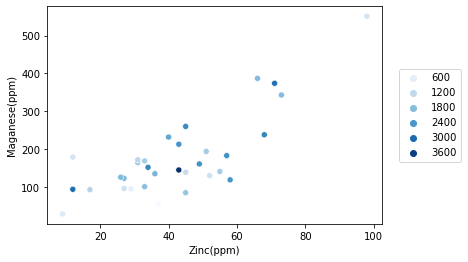

In [20]:
g=sns.scatterplot(data=df,x='Zinc(ppm)',y='Maganese(ppm)',hue='Yield (lbs/acre)',palette='Blues')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

### Check pairwise relationships

In [22]:
# Normalize data
from sklearn import preprocessing
mm_scaler= preprocessing.MinMaxScaler()
df_norm=pd.DataFrame(mm_scaler.fit_transform(df.drop(columns=['Sample Id ','Yield (lbs/acre)'])), columns=df.drop(columns=['Sample Id ','Yield (lbs/acre)']).columns)

In [23]:
# Add back yield and year
df_norm['Year']=df['Year']
df_norm['Yield (lbs/acre)']=df['Yield (lbs/acre)']

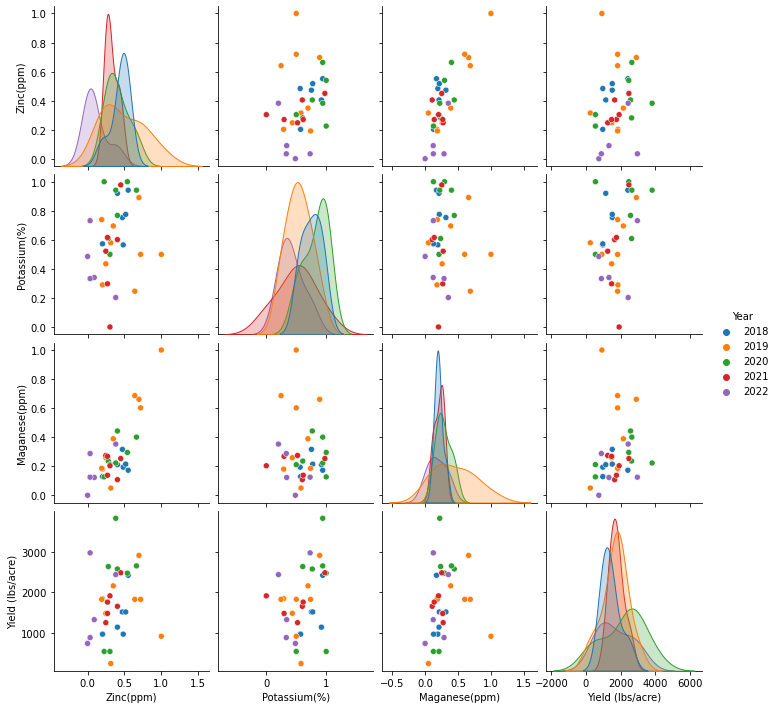

In [24]:
sns.pairplot(df_norm[['Zinc(ppm)','Potassium(%)','Maganese(ppm)','Yield (lbs/acre)','Year']],hue='Year',palette='tab10')

### PCA

In [25]:
# Run PCA with 6 components
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df_norm.drop(columns=['Year','Yield (lbs/acre)']))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6'])

Text(0, 0.5, 'Fraction of variance explained')

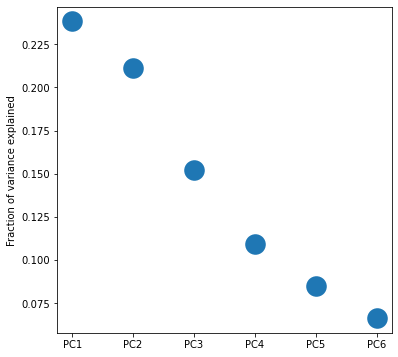

In [26]:
# Check distribution of eigenvalues
plt.rcParams['figure.figsize']=(6,6) #rescale figures

sns.scatterplot(x=pd.Series(pca.explained_variance_ratio_,index=['PC1','PC2','PC3','PC4','PC5','PC6']).index,
            y=pd.Series(pca.explained_variance_ratio_,index=['PC1','PC2','PC3','PC4','PC5','PC6']).values,
               s=500)
plt.ylabel('Fraction of variance explained')

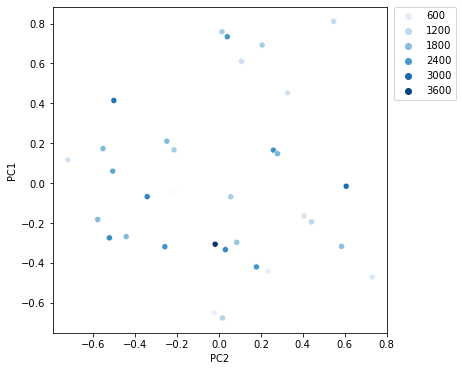

In [27]:
# Project the data onto the first 2 PCs, color by yield
principalDf['Yield (lbs/acre)']=df_norm['Yield (lbs/acre)'].values
g=sns.scatterplot(data=principalDf,x='PC2',y='PC1',hue='Yield (lbs/acre)',palette='Blues')
g.set_xlabel('PC2')
g.set_ylabel('PC1')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

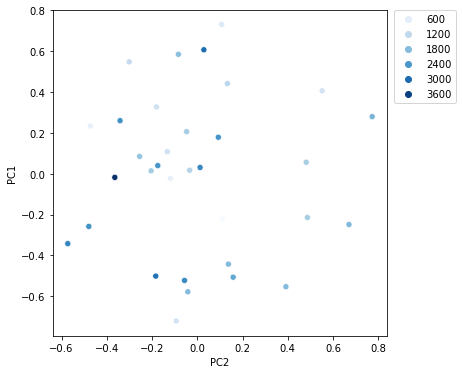

In [28]:
# Project the data onto the first 2 PCs, color by yield
principalDf['Yield (lbs/acre)']=df_norm['Yield (lbs/acre)'].values
g=sns.scatterplot(data=principalDf,x='PC3',y='PC2',hue='Yield (lbs/acre)',palette='Blues')
g.set_xlabel('PC2')
g.set_ylabel('PC1')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

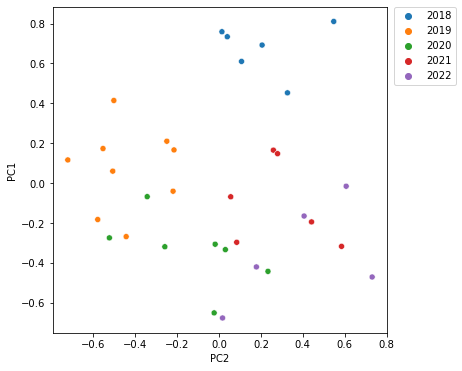

In [29]:
# Project the data onto the first 2 PCs, color by year
plt.rcParams['figure.figsize']=(6,6) #rescale figures
g=sns.scatterplot(data=principalDf,x='PC2',y='PC1',hue=df['Year'].values,palette='tab10')
g.set_xlabel('PC2')
g.set_ylabel('PC1')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## PCA splits samples by year, check the loadings

In [30]:
# Get the PCs loadings
loadings=pd.DataFrame(pca.components_).transpose()
loadings.columns=(['PC'+i.astype(str) for i in np.arange(len(pca.components_)+1)[1:]])
loadings.index=df_norm.drop(columns=['Year','Yield (lbs/acre)']).columns.values
loadings['names']=loadings.index.values

Text(0.5, 0, '')

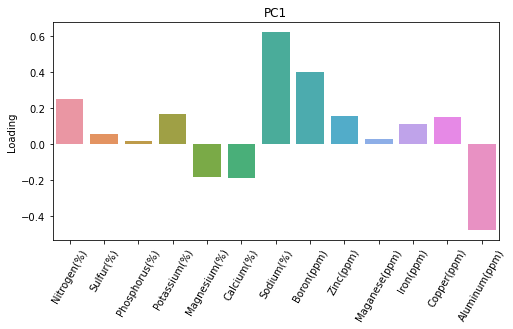

In [31]:
plt.rcParams['figure.figsize']=(8,4) #rescale figures

g=sns.barplot(data=loadings,y='PC1',x='names')
for item in g.get_xticklabels():
    item.set_rotation(60)
plt.xticks(ticks=np.arange(len(loadings)),labels=loadings.names)
plt.title('PC1')
plt.ylabel('Loading')
plt.xlabel('')

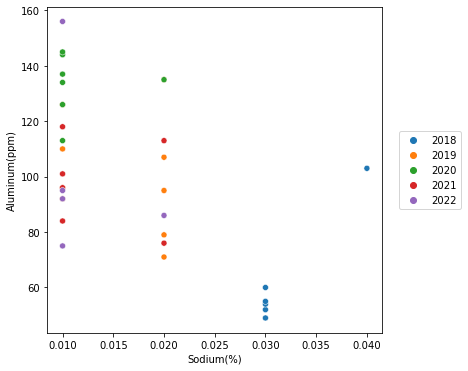

In [32]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures

g=sns.scatterplot(data=df,x='Sodium(%)',y='Aluminum(ppm)',hue='Year',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

Text(0.5, 0, '')

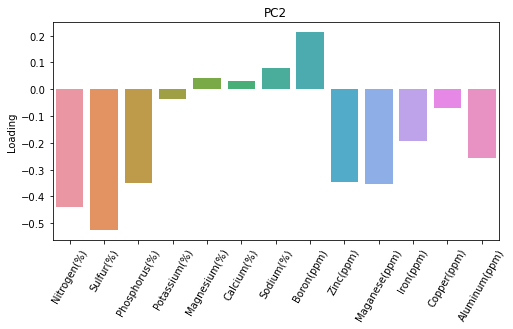

In [33]:
plt.rcParams['figure.figsize']=(8,4) #rescale figures
g=sns.barplot(data=loadings,y='PC2',x='names')
for item in g.get_xticklabels():
    item.set_rotation(60)
plt.xticks(ticks=np.arange(len(loadings)),labels=loadings.names)
plt.title('PC2')
plt.ylabel('Loading')
plt.xlabel('')

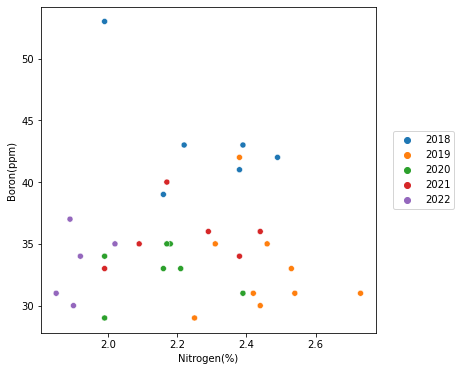

In [34]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures

g=sns.scatterplot(data=df,x='Nitrogen(%)',y='Boron(ppm)',hue='Year',palette='tab10')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)

### Exclude 2018 and check again for correlations

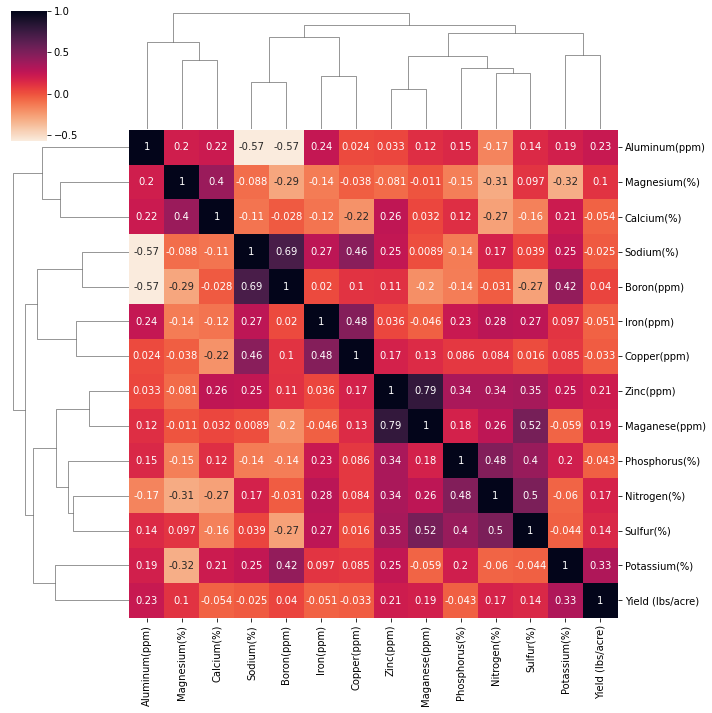

In [35]:
sns.clustermap(df[df['Year']!='2018'].drop(columns=['Sample Id ','Year']).corr(),cmap="rocket_r",annot=True)

In [36]:
df.shape

(33, 16)